#  Model Training with MLflow Tracking

This notebook demonstrates comprehensive machine learning model training for fraud detection with MLflow experiment tracking. We'll train multiple models, perform hyperparameter optimization, and track all experiments for reproducibility.

## Notebook Objectives:
- **Model Training**: Multiple algorithms with hyperparameter optimization
- **MLflow Integration**: Comprehensive experiment tracking
- **Model Evaluation**: Detailed performance analysis
- **Model Comparison**: Compare different approaches
- **Best Model Selection**: Choose optimal model for deployment

## Learning Objectives

- Reuse the shared pipeline to obtain train/validation/test splits
- Compare model performance tracked via MLflow
- Capture evaluation artefacts and export the trained model for inference


## Setup and Data Loading

In [15]:
# Core imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import json
warnings.filterwarnings('ignore')

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# Project modules
from src.config import ConfigManager
from src.pipelines import run_data_preparation, run_training_pipeline

# Evaluation helpers
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
print("INFO: Training notebook initialised at", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


INFO: Training notebook initialised at 2025-10-01 16:01:20


In [16]:
config_manager = ConfigManager()
config = config_manager.get_training_config()

print('INFO: Training configuration loaded')
print(f"   - Fraud rate: {config['data']['fraud_rate']:.1%}")
print(f"   - Target column: {config['features']['target_column']}")
print(f"   - MLflow experiment: {config['mlflow']['experiment_name']}")


2025-10-01 16:01:21,951 - src.config - INFO - Loaded configuration: training_config


INFO: Training configuration loaded
   - Fraud rate: 2.0%
   - Target column: is_fraud
   - MLflow experiment: fraud-detection


In [17]:
data_outputs = run_data_preparation(config, regenerate_data=False, persist=False)

feature_names = data_outputs['feature_names']

df = data_outputs['features'].copy()
X_train, y_train = data_outputs['splits']['train']
X_val, y_val = data_outputs['splits'].get('validation', (None, None))
X_test, y_test = data_outputs['splits']['test']

print('INFO: Data splits ready:')
print(f"   - Train: {X_train.shape}")
if X_val is not None:
    print(f"   - Validation: {X_val.shape}")
print(f"   - Test: {X_test.shape}")

selected_features = feature_names


2025-10-01 16:01:25,324 - src.data_processing - INFO - Data validation passed
2025-10-01 16:01:25,325 - src.data_processing - INFO - Starting data cleaning
2025-10-01 16:01:25,378 - src.data_processing - INFO - Capping 100 amount outliers at $1437.85
2025-10-01 16:01:25,438 - src.data_processing - INFO - Data cleaning completed. Shape: (100000, 20)
2025-10-01 16:01:25,439 - src.features - INFO - Creating all engineered features
2025-10-01 16:01:25,439 - src.features - INFO - Creating temporal features
2025-10-01 16:01:25,481 - src.features - INFO - Created temporal features: hour_of_day, day_of_week, is_weekend, time_category, is_business_hours, is_late_night
2025-10-01 16:01:25,482 - src.features - INFO - Creating amount-based features
2025-10-01 16:01:25,500 - src.features - INFO - Created amount features: amount_log, amount_category, round amount indicators
2025-10-01 16:01:25,504 - src.features - INFO - Creating user behavior features
2025-10-01 16:01:25,554 - src.features - INFO -

INFO: Data splits ready:
   - Train: (60000, 52)
   - Validation: (20000, 52)
   - Test: (20000, 52)


In [18]:
training_result = run_training_pipeline(config, regenerate_data=False, persist_data=True, save_model=True)

trainer = training_result['trainer']
best_model_name = training_result['best_model_name']
best_model_metrics = training_result['best_model_metrics']
test_metrics = training_result['test_metrics']
best_model = trainer.best_models.get(best_model_name)

print(f"Best model selected: {best_model_name}")
print("Validation metrics:")
for metric, value in (best_model_metrics or {}).items():
    print(f"   - {metric}: {value:.4f}")

if test_metrics:
    print("Test metrics:")
    for metric, value in test_metrics.items():
        print(f"   - {metric}: {value:.4f}")


2025-10-01 16:03:08,745 - src.data_processing - INFO - Data validation passed
2025-10-01 16:03:08,746 - src.data_processing - INFO - Starting data cleaning
2025-10-01 16:03:08,801 - src.data_processing - INFO - Capping 100 amount outliers at $1437.85
2025-10-01 16:03:08,879 - src.data_processing - INFO - Data cleaning completed. Shape: (100000, 20)
2025-10-01 16:03:08,880 - src.features - INFO - Creating all engineered features
2025-10-01 16:03:08,881 - src.features - INFO - Creating temporal features
2025-10-01 16:03:08,925 - src.features - INFO - Created temporal features: hour_of_day, day_of_week, is_weekend, time_category, is_business_hours, is_late_night
2025-10-01 16:03:08,926 - src.features - INFO - Creating amount-based features
2025-10-01 16:03:08,945 - src.features - INFO - Created amount features: amount_log, amount_category, round amount indicators
2025-10-01 16:03:08,949 - src.features - INFO - Creating user behavior features
2025-10-01 16:03:09,001 - src.features - INFO -

Fitting 3 folds for each of 2 candidates, totalling 6 fits


2025-10-01 16:03:20,765 - src.train - INFO - Grid search completed. Best score: 0.6697
2025-10-01 16:03:20,766 - src.train - INFO - Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'liblinear'}
2025/10/01 16:03:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025-10-01 16:03:23,413 - src.train - INFO - Validation ROC AUC: 0.6772
2025-10-01 16:03:23,414 - src.train - INFO - Completed training logistic_regression
2025-10-01 16:03:23,417 - src.train - INFO - Training random_forest model


Fitting 3 folds for each of 2 candidates, totalling 6 fits


2025-10-01 16:03:37,197 - src.train - INFO - Grid search completed. Best score: 0.6787
2025-10-01 16:03:37,197 - src.train - INFO - Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
2025/10/01 16:03:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025-10-01 16:03:40,216 - src.train - INFO - Validation ROC AUC: 0.6741
2025-10-01 16:03:40,216 - src.train - INFO - Completed training random_forest
2025-10-01 16:03:40,218 - src.train - INFO - Best model: logistic_regression
Registered model 'fraud-detector' already exists. Creating a new version of this model...
2025/10/01 16:03:40 WARNING mlflow.tracking._model_registry.fluent: Run with id 536b600f212345d2b70bdff9a4091443 has no artifacts at artifact path 'logistic_regression', registering model based on models:/m-490faf8cc8594b429af487259f1ad8e5 instead
Created version '6' of model 'fraud-detector'.
2025-10-01 16:03:40,280 - src.train - INFO - Re

Best model selected: logistic_regression
Validation metrics:
   - train_accuracy: 0.6476
   - train_precision: 0.0349
   - train_recall: 0.6233
   - train_f1: 0.0661
   - train_roc_auc: 0.6855
   - train_avg_precision: 0.0471
   - val_accuracy: 0.6474
   - val_precision: 0.0340
   - val_recall: 0.6075
   - val_f1: 0.0645
   - val_roc_auc: 0.6772
   - val_avg_precision: 0.0432
Test metrics:
   - test_accuracy: 0.6495
   - test_precision: 0.0315
   - test_recall: 0.5550
   - test_f1: 0.0596
   - test_roc_auc: 0.6572
   - test_avg_precision: 0.0408


In [19]:
def show_model_metrics(model_name: str):
    """Pretty-print metrics for a trained model when available."""
    if 'trainer' not in globals():
        print('Trainer instance not available. Run the training pipeline cell first.')
        return

    metrics = trainer.model_metrics.get(model_name) if trainer.model_metrics else None
    if not metrics:
        print(f"- Metrics for '{model_name}' are not available yet. Execute the training cell above.")
        return

    print(f"Model: {model_name}")
    for metric, value in metrics.items():
        print(f"   - {metric}: {value:.4f}")

    best_estimator = trainer.best_models.get(model_name)
    if best_estimator is not None and hasattr(best_estimator, 'get_params'):
        tuned_params = getattr(best_estimator, 'get_params')()
        key_params = {k: tuned_params[k] for k in ['C', 'solver', 'max_depth', 'n_estimators'] if k in tuned_params}
        if key_params:
            print('   - Key hyperparameters:')
            for param, value in key_params.items():
                print(f"       {param}: {value}")

    run_id = trainer.model_run_ids.get(model_name)
    if run_id:
        print(f"   - MLflow run: {run_id}")


## Processing: Data Preparation for Training

In [20]:
# Prepare features for inspection straight from the pipeline outputs
train_features = X_train.copy()
train_target = y_train.copy()

print('Data: Training Data Preparation:')
print(f"   - Features shape: {train_features.shape}")
print(f"   - Target shape: {train_target.shape}")
print(f"   - Positive class rate (train): {train_target.mean():.3f}")

sample_preview = train_features.head().copy()
sample_preview['is_fraud'] = train_target.head().values
sample_preview.head()


Data: Training Data Preparation:
   - Features shape: (60000, 52)
   - Target shape: (60000,)
   - Positive class rate (train): 0.020


,amount,merchant_category,transaction_type,device_type,location,hour_of_day,day_of_week,is_weekend,user_transaction_count,user_avg_amount,user_std_amount,user_unique_categories,user_unique_devices,user_unique_locations,amount_zscore,day_of_month,month,time_category,is_business_hours,is_late_night,amount_log,amount_category,is_round_amount,is_round_10,is_round_100,user_max_amount,amount_ratio_to_user_avg,amount_ratio_to_user_max,is_amount_outlier,time_since_last_transaction,hours_since_last_transaction,transactions_per_day,is_quick_transaction,is_very_quick_transaction,is_usual_location,device_atm,device_desktop,device_mobile,device_pos_terminal,device_tablet,is_usual_device,merchant_entertainment,merchant_gas_station,merchant_grocery,merchant_healthcare,merchant_online,merchant_pharmacy,merchant_restaurant,merchant_retail,merchant_travel,merchant_utilities,is_usual_merchant_category,is_fraud
39008,58.77,6.0,3.0,2.0,1.0,23,1,0,12,60.475395,93.901472,6,3,5,-0.017970,5,8,3.0,0,1,4.090504,2.0,0,0,0,352.27,0.955992,0.166360,0,506340.0,140.650000,0.400000,0,0,1,False,False,True,False,False,1,False,False,False,False,False,False,True,False,False,False,1,False
76566,10.84,1.0,4.0,2.0,3.0,12,0,0,5,36.788000,56.770264,3,3,3,-0.449158,8,9,1.0,1,0,2.471484,0.0,0,0,0,137.11,0.286864,0.078488,0,5360760.0,1489.100000,0.166667,0,0,0,False,False,True,False,False,1,False,True,False,False,False,False,False,False,False,False,1,False
14402,3.45,8.0,1.0,4.0,2.0,11,0,0,13,40.928462,44.122018,7,2,5,-0.830603,14,7,1.0,1,0,1.492904,0.0,0,0,0,137.92,0.082283,0.024834,0,700680.0,194.633333,0.433333,0,0,0,False,False,False,False,True,0,False,False,False,False,False,False,False,False,True,False,0,False
27950,13.99,1.0,1.0,2.0,2.0,14,5,1,7,17.388571,8.399955,4,2,3,-0.361552,26,7,2.0,0,0,2.707383,0.0,0,0,0,30.63,0.760799,0.442302,0,369540.0,102.650000,0.233333,0,0,1,False,False,True,False,False,1,False,True,False,False,False,False,False,False,False,False,1,False
58874,264.12,5.0,1.0,2.0,2.0,12,5,1,10,79.737000,96.436820,6,2,5,1.892334,23,8,1.0,0,0,5.580183,3.0,0,0,0,264.12,3.271363,0.996228,0,1737600.0,482.666667,0.333333,0,0,1,False,False,True,False,False,0,False,False,False,False,False,True,False,False,False,False,0,False


## MLflow Training Helper Functions

In [21]:
def evaluate_model(model, X_data, y_data, model_name: str):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)[:, 1]

    metrics = {
        'accuracy': accuracy_score(y_data, y_pred),
        'precision': precision_score(y_data, y_pred),
        'recall': recall_score(y_data, y_pred),
        'f1_score': f1_score(y_data, y_pred),
        'roc_auc': roc_auc_score(y_data, y_proba),
        'average_precision': average_precision_score(y_data, y_proba),
    }

    print(f"Evaluation for {model_name}:")
    for metric, value in metrics.items():
        print(f"   - {metric}: {value:.4f}")

    cm = confusion_matrix(y_data, y_pred)
    fpr, tpr, _ = roc_curve(y_data, y_proba)
    precision, recall, _ = precision_recall_curve(y_data, y_proba)

    return metrics, cm, (fpr, tpr), (precision, recall), y_pred, y_proba


## OBJECTIVE: Model Training Pipeline

We'll train multiple models with hyperparameter optimization and track everything with MLflow.

In [22]:
# Random Forest (pipeline managed)
show_model_metrics('random_forest')

Model: random_forest
   - train_accuracy: 0.7511
   - train_precision: 0.0453
   - train_recall: 0.5700
   - train_f1: 0.0839
   - train_roc_auc: 0.7293
   - train_avg_precision: 0.0708
   - val_accuracy: 0.7480
   - val_precision: 0.0377
   - val_recall: 0.4725
   - val_f1: 0.0698
   - val_roc_auc: 0.6741
   - val_avg_precision: 0.0413
   - Key hyperparameters:
       max_depth: 5
       n_estimators: 100
   - MLflow run: 5427c5bed2374935a7634a736547c3c4


## Data: Model Comparison and Final Evaluation

Data: Model Performance Comparison
                     train_accuracy  train_precision  train_recall  train_f1  \
logistic_regression          0.6476           0.0349        0.6233    0.0661   
random_forest                0.7512           0.0453        0.5700    0.0839   

                     train_roc_auc  train_avg_precision  val_accuracy  \
logistic_regression         0.6855               0.0471        0.6474   
random_forest               0.7293               0.0708        0.7480   

                     val_precision  val_recall  val_f1  val_roc_auc  \
logistic_regression         0.0340      0.6075  0.0645       0.6772   
random_forest               0.0377      0.4725  0.0698       0.6741   

                     val_avg_precision  
logistic_regression             0.0432  
random_forest                   0.0413  


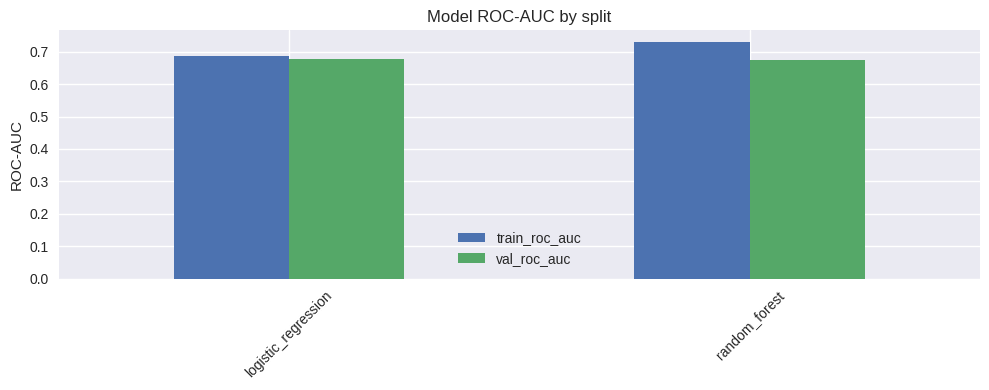

Best model: logistic_regression
   - train_accuracy: 0.6476
   - train_precision: 0.0349
   - train_recall: 0.6233
   - train_f1: 0.0661
   - train_roc_auc: 0.6855
   - train_avg_precision: 0.0471
   - val_accuracy: 0.6474
   - val_precision: 0.0340
   - val_recall: 0.6075
   - val_f1: 0.0645
   - val_roc_auc: 0.6772
   - val_avg_precision: 0.0432
Meets minimum requirements: No


In [23]:
print("Data: Model Performance Comparison")
print("=" * 50)

models_results = trainer.model_metrics
comparison_df = pd.DataFrame(models_results).T.round(4) if models_results else pd.DataFrame()
if comparison_df.empty:
    print('No model metrics available. Run the training cell above first.')
else:
    print(comparison_df)
    comparison_df[['train_roc_auc', 'val_roc_auc']].plot(kind='bar', figsize=(10, 4), ylabel='ROC-AUC', title='Model ROC-AUC by split')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

best_model_name = training_result['best_model_name']
best_model_metrics = models_results.get(best_model_name, {}) if best_model_name else {}

print(f"Best model: {best_model_name}")
for metric, value in best_model_metrics.items():
    print(f"   - {metric}: {value:.4f}")

min_metrics = config['evaluation']['minimum_metrics']
meets_requirements = bool(best_model_metrics) and all(
    best_model_metrics.get(metric, 0) >= threshold
    for metric, threshold in min_metrics.items()
)
print(f"Meets minimum requirements: {'Yes' if meets_requirements else 'No'}")


In [24]:
print("OBJECTIVE: Final Evaluation on Test Set")
print("=" * 40)

if best_model is None:
    raise ValueError('Best model not available from pipeline output')

metrics, cm, roc_points, pr_points, y_test_pred, y_test_proba = evaluate_model(
    best_model,
    X_test,
    y_test,
    best_model_name or 'model'
)

print("Test metrics (recomputed for verification):")
for metric, value in metrics.items():
    print(f"   - {metric}: {value:.4f}")


OBJECTIVE: Final Evaluation on Test Set
Evaluation for logistic_regression:
   - accuracy: 0.6495
   - precision: 0.0315
   - recall: 0.5550
   - f1_score: 0.0596
   - roc_auc: 0.6572
   - average_precision: 0.0408
Test metrics (recomputed for verification):
   - accuracy: 0.6495
   - precision: 0.0315
   - recall: 0.5550
   - f1_score: 0.0596
   - roc_auc: 0.6572
   - average_precision: 0.0408


## Info: Training Summary & Next Steps

In [25]:
print(" MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 50)

print("Data: Training Dataset Overview:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Features used: {len(selected_features)}")
print(f"   • Fraud rate: {df['is_fraud'].mean():.2%}")
print(f"   • Training split: {len(X_train)} / {len(X_val) if X_val is not None else 0} / {len(X_test)} (train/val/test)")

print(f"Best Model: {best_model_name}")
if test_metrics:
    for metric, value in test_metrics.items():
        print(f"   • Test {metric}: {value:.4f}")
else:
    print('   • Test metrics not available yet.')

best_params = {}
if best_model_name in trainer.models:
    candidate = trainer.models[best_model_name]
    if hasattr(candidate, 'best_params_'):
        best_params = candidate.best_params_

if best_params:
    print("Feature: Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"   • {param}: {value}")

if hasattr(best_model, 'feature_importances_'):
    importance = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)
    top_feature = importance.index[0]
    top_importance = importance.iloc[0]
    print(f"Most important feature: {top_feature} ({top_importance:.3f})")

print("SAVE: Deliverables:")
print(f"   • Final model saved: {training_result['model_artifact_path']}")
print(f"   • Training summary: {training_result['summary_path']}")

training_summary = {
    'timestamp': datetime.now().isoformat(),
    'dataset_size': len(df),
    'features_used': len(selected_features),
    'fraud_rate': float(df['is_fraud'].mean()),
    'best_model': best_model_name,
    'test_metrics': {k: float(v) for k, v in (test_metrics or {}).items()},
    'model_file': str(training_result['model_artifact_path']) if training_result['model_artifact_path'] else None,
}

summary_path = Path('../data/training_summary.json')
summary_path.parent.mkdir(parents=True, exist_ok=True)
summary_path.write_text(json.dumps(training_summary, indent=2))
print(f"Training summary saved to: {summary_path}")


 MODEL TRAINING COMPLETED SUCCESSFULLY!
Data: Training Dataset Overview:
   • Total samples: 100,000
   • Features used: 52
   • Fraud rate: 2.00%
   • Training split: 60000 / 20000 / 20000 (train/val/test)
Best Model: logistic_regression
   • Test test_accuracy: 0.6495
   • Test test_precision: 0.0315
   • Test test_recall: 0.5550
   • Test test_f1: 0.0596
   • Test test_roc_auc: 0.6572
   • Test test_avg_precision: 0.0408
Feature: Best Hyperparameters:
   • C: 1.0
   • class_weight: balanced
   • max_iter: 500
   • solver: liblinear
SAVE: Deliverables:
   • Final model saved: models/logistic_regression_final_model.joblib
   • Training summary: data/training_summary.json
Training summary saved to: ../data/training_summary.json
